In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import sklearn
from tqdm.notebook import tqdm
from collections import Counter
import time

plt.style.use('seaborn')
np.__version__

/tmp/ipykernel_34712/2660579219.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


'1.24.4'

In [3]:
data = np.load('data.npy', allow_pickle=True)
data.shape

(1500, 5)

In [4]:
def reshape_data(data):
    temp = []
    for d in data:
        temp.append(d.reshape(-1, 1))
    temp = np.array(temp)
    temp = temp - np.mean(temp)
    temp = temp/(np.var(temp) ** 0.5)
    return temp


resnet, vit, y = reshape_data(data[:, 1]), reshape_data(data[:, 2]), data[:, 3]
resnet.shape, vit.shape, y.shape


((1500, 1024, 1), (1500, 512, 1), (1500,))

# Task 1

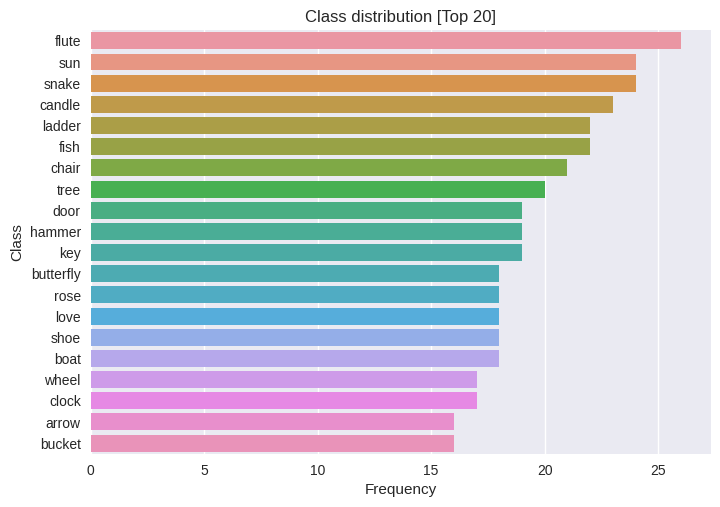

In [5]:
def plot_class_dist(n = 10):
    freq_table = pd.Series(y).value_counts()
    cates, freq = freq_table.keys()[:n], freq_table.values[:n]
    sea.barplot(y = cates, x = freq)
    plt.title(f'Class distribution [Top {n}]')
    plt.xlabel('Frequency')
    plt.ylabel('Class')
    plt.show()
    
plot_class_dist(n = 20)

In [6]:
from sklearn.model_selection import train_test_split

resnet_x_train, resnet_x_val, resnet_y_train, resnet_y_val = train_test_split(resnet, y, test_size = 0.2)
vit_x_train, vit_x_val, vit_y_train, vit_y_val = train_test_split(vit, y, test_size = 0.2)


In [7]:
train_data = {
    'resnet' : {'X' : resnet_x_train, 'y' : resnet_y_train },
    'vit' : {'X' : vit_x_train, 'y' : vit_y_train} 
}

val_data = {
    'resnet' : {'X': resnet_x_val, 'y' : resnet_y_val},
    'vit' : {'X' : vit_x_val, 'y' : vit_y_val}
}


In [8]:
def euclidean(x, y, optimized=False):
    return np.sqrt(np.sum((x - y) ** 2, axis=1)) if not optimized else (
        np.sqrt(np.sum((x - y[:, np.newaxis, :]) ** 2, axis=2)).squeeze(-1))

def manhattan(x, y, optimized=False):
    return np.sum(np.abs(x - y), axis=1) if not optimized else (
        np.sum(np.abs(x - y[:, np.newaxis, :]), axis=2).squeeze(-1))

def cosine(x, y, optimized=False):
    if len(x.shape) == 3:
        x, y = x.squeeze(axis = -1), y.squeeze(axis = -1)
    return 1 - (np.sum(x * y, axis = -1)/(np.linalg.norm(x, axis = -1) * np.linalg.norm(y, axis = -1)))

features_scalers = {
    'standardization': sklearn.preprocessing.StandardScaler(),
    'min_max': sklearn.preprocessing.MinMaxScaler(),
    'robust': sklearn.preprocessing.RobustScaler()
}


In [9]:

def most_common(arr):
    counts = np.bincount(arr)
    return np.argmax(counts)

x, y = np.array([[3, 4], [5, 0], [4, 4]]), np.array([[2, 4], [0, 1]])
x, y = x.reshape(-1, 2, 1), y.reshape(-1, 2, 1)
print(x.shape, y.shape)
# x = (3, 2, 1), y = (1, 2, 1)
# dis = (1, 3) | 1 is the number of points in y and 3 is the number of points in x


(3, 2, 1) (2, 2, 1)


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

class KNNModel:
    def __init__(self, encoder_type, k, distance_metric, scaler, metric_average, optimized=False):
        self.encoder= train_data[encoder_type]
        self.X = self.encoder['X']
        self.y = self.encoder['y']
        self.k = k
        self.distance_metric = distance_metric
        self.scaler = features_scalers[scaler]
        self.X = self.scaler.fit_transform(self.X.squeeze(-1))
        self.metric_average=metric_average
        self.optimized=optimized
        
    def forward_optimized(self, x):

        self.X, x = np.expand_dims(self.X, axis=-1), np.expand_dims(x, axis=-1)
        distances = np.array([self.distance_metric(self.X, i) for i in x])
        if len(distances.shape) == 3:
            distances = distances.squeeze(-1)
        min_k_idx = self.y[np.argsort(distances, axis=-1)[:, :self.k]]
        # pred = [pd.Series(row).value_counts().keys()[0] for row in min_k_idx]
        pred = [Counter(row).most_common(1)[0][0] for row in min_k_idx]    
        return pred
        
    def forward(self, x):
        # x : (512, 1) self.X: (1500, 512, 1) 
        # print(x.shape)
        distances = self.distance_metric(self.X, x)
        min_k_idx = np.argsort(distances.ravel())[:self.k]
        # pred = pd.Series(self.y[min_k_idx]).value_counts().keys()[0]
        pred = Counter(self.y[min_k_idx]).most_common(1)[0][0]
        return pred
        
    def get_scores(self, x_test, y_test):
        
        assert self.X.shape[1] == x_test.shape[1], (
            "Number of features in x_test={} not equal to original data features={}".format(x_test.shape[1], self.X.shape[1]))
        assert len(x_test) == len(y_test), (
            'Number of x_test={} not equal to y_test={}'.format(len(x_test), len(y_test)))
        
        start = time.time()
        
        x_test = self.scaler.transform(x_test.squeeze(-1))
        y_pred = []
        if self.optimized:
            y_pred = self.forward_optimized(x_test)
        else:
            for x in x_test:
                y_pred.append(self.forward(x))
                
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=self.metric_average)
        recall = recall_score(y_test, y_pred, average=self.metric_average)
        f1 = f1_score(y_test, y_pred, average=self.metric_average)
        
        start = time.time() - start
        
        return {
            # 'pred' : y_pred,
            'acc' : acc,
            'precision': precision,
            'recall' : recall,
            'f1' : f1,
            'time': start
        }
    
model1 = KNNModel(encoder_type='vit', 
                 k = 20, 
                 distance_metric=euclidean,
                 scaler='standardization',
                 metric_average='micro',
                 optimized=False)

model2 = KNNModel(encoder_type='vit', 
                k = 20,
                distance_metric=euclidean,
                metric_average='micro',
                scaler='standardization',
                optimized=True)


In [11]:
x_val, y_val = val_data['vit'].values()

output1 = model1.get_scores(x_val, y_val)
output2 = model2.get_scores(x_val, y_val)

output1, output2

({'acc': 0.28,
  'precision': 0.28,
  'recall': 0.28,
  'f1': 0.28,
  'time': 0.35089540481567383},
 {'acc': 0.28,
  'precision': 0.28,
  'recall': 0.28,
  'f1': 0.28,
  'time': 0.21110105514526367})

## Hyperparameter Tuning

## Task 2

In [12]:
params = {
    'encoder_type': ['vit', 'resnet'],
    'k': np.arange(1,20,1),
    'distance_metric': [euclidean, manhattan, cosine]
}


def tune(params):
    
    n_total = np.prod([len(i) for i in list(params.values())])
    bar = tqdm(total = n_total, desc='Hyperparameter Tuning')
    
    df = {'encoder': [], 'k' : [], 'distance_metric': [], 'acc': [], 'precision': [], 'recall': [], 'f1': []}
    
    for encoder in params['encoder_type']:
        for k in params['k']:
            for distance_metric in params['distance_metric']:
                model = KNNModel(encoder_type=encoder, 
                                 k=k, 
                                 distance_metric=distance_metric,
                                 scaler='standardization',
                                 metric_average='micro',
                                 optimized=True)
                
                x_val, y_val = val_data[encoder].values()
                output = model.get_scores(x_val, y_val)
                
                for (key, value) in zip(list(df.keys()), [encoder, k, distance_metric.__name__] + list(output.values())):
                    df[key].append(value)
                
                bar.update(1)
    
    df = pd.DataFrame(df)
    return df


df_result = tune(params=params).sort_values(by=['acc'], axis = 0, ascending=False)

Hyperparameter Tuning:   0%|          | 0/114 [00:00<?, ?it/s]

In [13]:
df_result[:100]

,encoder,k,distance_metric,acc,precision,recall,f1
29,vit,10,cosine,0.323333,0.323333,0.323333,0.323333
35,vit,12,cosine,0.316667,0.316667,0.316667,0.316667
32,vit,11,cosine,0.316667,0.316667,0.316667,0.316667
26,vit,9,cosine,0.313333,0.313333,0.313333,0.313333
41,vit,14,cosine,0.310000,0.310000,0.310000,0.310000
...,...,...,...,...,...,...,...
76,resnet,7,manhattan,0.240000,0.240000,0.240000,0.240000
112,resnet,19,manhattan,0.240000,0.240000,0.240000,0.240000
105,resnet,17,euclidean,0.240000,0.240000,0.240000,0.240000
69,resnet,5,euclidean,0.236667,0.236667,0.236667,0.236667


  0%|          | 0/19 [00:00<?, ?it/s]

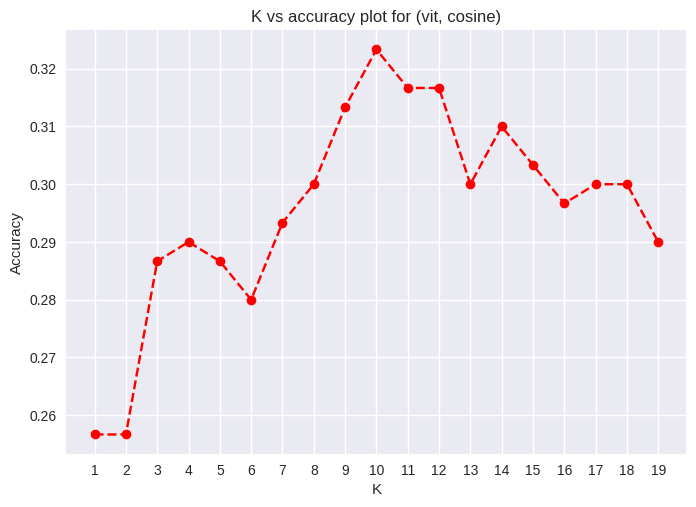

In [14]:
def plot_k_vs_accuracy(distance, encoder):
    x_val, y_val = val_data[encoder].values()
    
    ks, acc = [], []
    
    for k in tqdm(range(1, 20)):
        model = KNNModel(encoder_type=encoder, 
                         distance_metric=distance,
                         k = k,
                         scaler='standardization',
                         metric_average='micro',
                         optimized=True)
        output = model.get_scores(x_val, y_val)
        ks.append(k)
        acc.append(output['acc'])
        
    plt.plot(ks, acc, '--r', marker='o')
    plt.title(f'K vs accuracy plot for ({encoder}, {distance.__name__})')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.xticks(ks)
    plt.show()
    
plot_k_vs_accuracy(cosine, 'vit')
        

# Optimization

In [15]:
from sklearn.neighbors import KNeighborsClassifier

def run_default_model(encoder, k):
    X_train, y_train = train_data[encoder].values()
    X_val, y_val = val_data[encoder].values()
    model = KNeighborsClassifier(k).fit(X_train.squeeze(-1), y_train)
    start = time.time()
    y_pred = model.predict(X_val.squeeze(-1))
    start = time.time() - start
    return start


0.30769968032836914
0.2931828498840332
0.2947084903717041


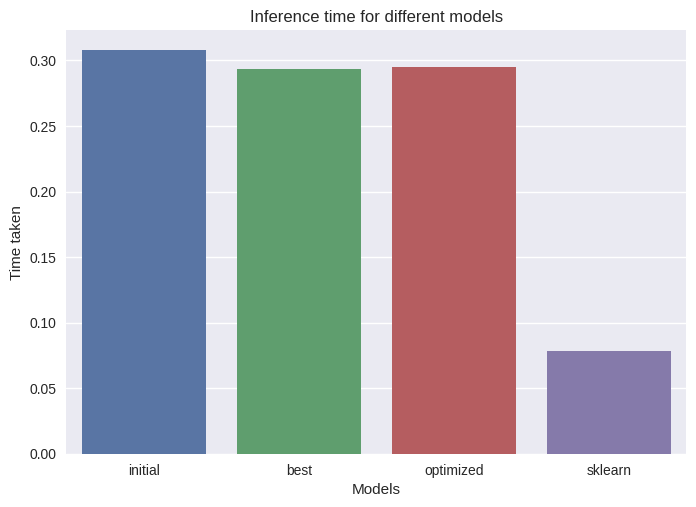

In [16]:
initial_model = KNNModel(
    encoder_type='vit',
    k = 20,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=False
)

best_model = KNNModel(
    encoder_type='vit',
    k = 7,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=False
)

optimized_model = KNNModel(
    encoder_type='vit',
    k = 10,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=True
)

def plot_inference_times():
    models = [initial_model, best_model, optimized_model]
    time_taken = []
    encoder = 'vit'
    
    X_val, y_val = val_data[encoder].values()
    for model in models:
        output = model.get_scores(X_val, y_val)
        time_taken.append(output['time'])
        print(output['time'])
        
    time_taken.append(run_default_model(encoder, k=20))
    
    sea.barplot(x = ['initial', 'best', 'optimized', 'sklearn'], y = time_taken)
    plt.title('Inference time for different models')
    plt.xlabel('Models')
    plt.ylabel('Time taken')
    plt.show()
    
        
plot_inference_times()

In [17]:
train_data['vit']['X'].shape

(1200, 512, 1)

In [22]:
initial_model = KNNModel(
    encoder_type='vit',
    k = 20,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=False
)

best_model = KNNModel(
    encoder_type='vit',
    k = 7,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=False
)

optimized_model = KNNModel(
    encoder_type='vit',
    k = 10,
    distance_metric=cosine,
    metric_average='micro',
    scaler='standardization',
    optimized=True
)


def plot_time_vs_dataset_size(model, encoder):
    
    X_train, y_train = model.X, model.y
    X_val, y_val = val_data[encoder].values()
    time_taken = []
    
    for i in tqdm(range(40)):
        model.X = X_train[:(30 * (i + 1)), :]
        model.y = y_train[:(30 * (i + 1))]
        output = model.get_scores(X_val, y_val)
        time_taken.append(output['time'])
        
    return time_taken

def get_sklearn_model_time(encoder):
    X_train, y_train = train_data[encoder].values()
    X_val, y_val = val_data[encoder].values()
    time_taken = []
    
    for i in tqdm(range(40)):
        X_t = X_train[:(30 * (i + 1)), :]
        y_t = y_train[:(30 * (i + 1))]
        model = KNeighborsClassifier(10).fit(X_t.squeeze(-1), y_t)
        start = time.time()
        model.predict(X_val.squeeze(-1))
        time_taken.append(time.time() - start)
        
    return time_taken


initial_model_time = plot_time_vs_dataset_size(initial_model, 'vit')
best_model_time = plot_time_vs_dataset_size(best_model, 'vit')
optimized_model_time = plot_time_vs_dataset_size(optimized_model, 'vit')
sklearn_model_time = get_sklearn_model_time('vit')



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

[]

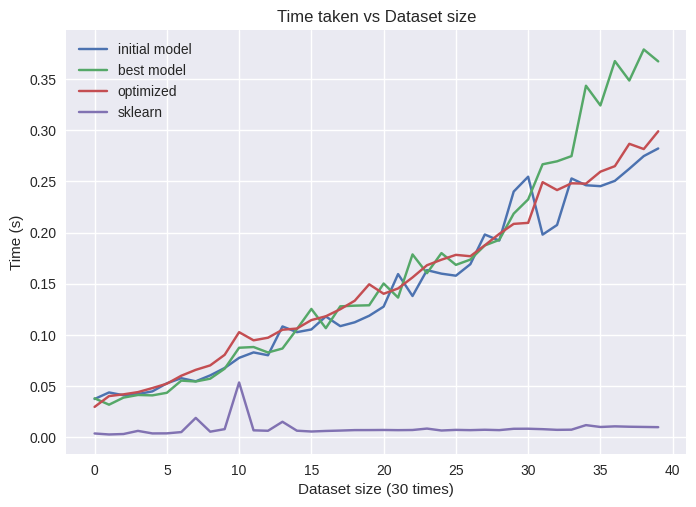

In [23]:
plt.title('Time taken vs Dataset size')

plt.plot(initial_model_time, label='initial model')
plt.plot(best_model_time, label='best model')
plt.plot(optimized_model_time, label='optimized')
plt.plot(sklearn_model_time, label='sklearn')

plt.xlabel('Dataset size (30 times)')
plt.ylabel('Time (s)')
plt.legend()
plt.plot()

# Multilabel Classification

In [24]:
df = pd.read_csv('./advertisement.csv')
df.head(10)

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home
5,20,Female,51266.767047,Master,True,3,Frankport,Scientist,95.145103,laptop,sports electronics books
6,27,Male,29578.136416,Bachelor,True,3,North Shelbyshire,Lawyer,69.022842,table,beauty furniture clothing
7,20,Female,35325.309005,PhD,False,3,South Raventown,Housewife,110.564517,dictionary,books beauty
8,51,Male,40232.564356,PhD,True,0,Leonardtown,Salesman,107.835490,curtains,electronics food home sports
9,19,Male,48053.583882,PhD,True,0,South Susan,Artist,108.854898,chips,furniture food


In [25]:
df.describe()

,age,income,children,purchase_amount
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.836000,49349.796167,1.508000,101.098170
std,13.786848,9894.479148,1.129253,20.348736
min,18.000000,21908.867759,0.000000,23.482179
25%,28.000000,42577.352034,0.000000,87.699577
50%,41.000000,48993.757137,1.000000,101.587560
75%,53.000000,56566.795992,3.000000,114.718926
max,64.000000,79459.294416,3.000000,168.978628


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool   
 5   children          1000 non-null   int64  
 6   city              1000 non-null   object 
 7   occupation        1000 non-null   object 
 8   purchase_amount   1000 non-null   float64
 9   most bought item  1000 non-null   object 
 10  labels            1000 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.2+ KB


<Axes: title={'center': 'Distribution of purchase amount'}, xlabel='purchase_amount', ylabel='Count'>

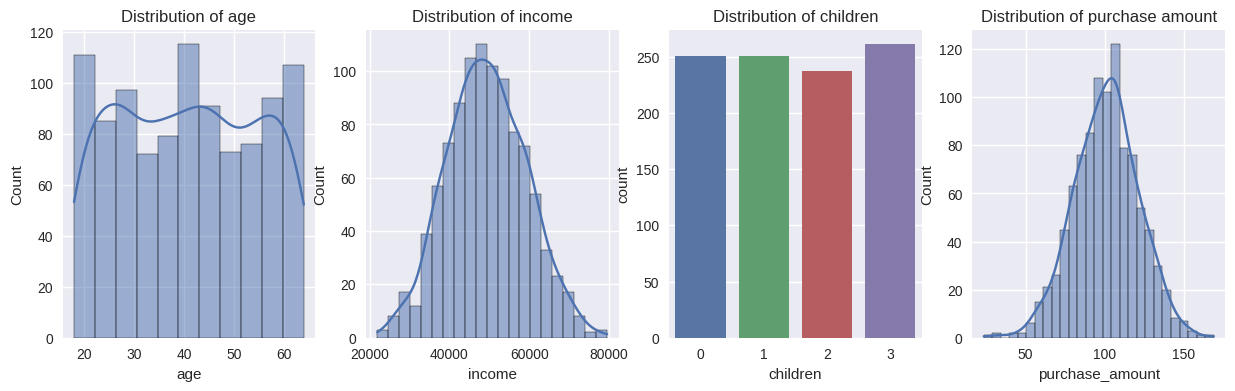

In [27]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
plt.title('Distribution of age')
sea.histplot(x = 'age', data = df, kde=True)

plt.subplot(1, 4, 2)
plt.title('Distribution of income')
sea.histplot(x = 'income', data = df, kde=True)

plt.subplot(1, 4, 3)
plt.title('Distribution of children')
sea.countplot(x = 'children', data = df)

plt.subplot(1, 4, 4)
plt.title('Distribution of purchase amount')
sea.histplot(x = 'purchase_amount', data = df, kde=True)



<Axes: xlabel='income', ylabel='occupation'>

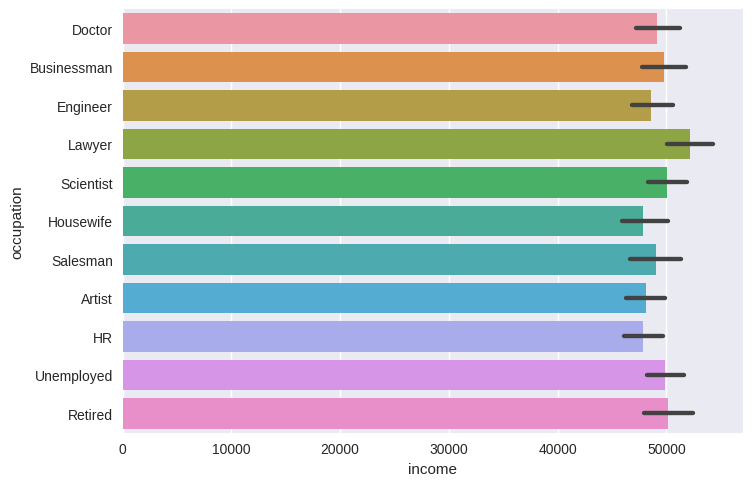

In [28]:
sea.barplot(y = 'occupation', x = 'income', data= df)

<Axes: xlabel='count', ylabel='most bought item'>

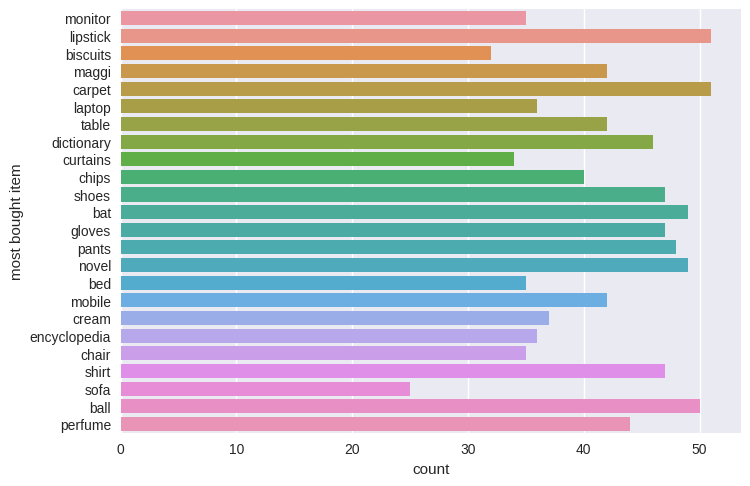

In [29]:
sea.countplot(y = 'most bought item', data=df)

## Model

In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
cols = ['gender', 'education', 'married', 'occupation', 'most bought item']
df[cols] = df[cols].apply(lambda x : label_encoder.fit_transform(x))

df = df.drop(columns=['city'], axis = 0)
df['labels'] = df['labels'].map(lambda x : " ".join(np.sort(x.split(" "))))
df

,age,gender,income,education,married,children,occupation,purchase_amount,most bought item,labels
0,45,1,61271.953359,2,0,3,2,87.697118,16,clothing electronics sports
1,24,0,53229.101074,1,0,1,1,115.135586,13,beauty furniture
2,45,0,30066.046684,0,1,3,3,101.694559,3,clothing electronics food sports
3,19,1,48950.246384,3,0,0,6,97.964887,14,food
4,29,0,44792.627094,2,0,0,1,86.847281,4,home
...,...,...,...,...,...,...,...,...,...,...
995,61,1,34246.773063,2,1,3,4,103.357441,2,food furniture
996,56,0,45494.225591,0,0,0,3,85.159023,3,clothing food home
997,64,0,68740.442006,3,1,0,8,101.434650,1,clothing sports
998,18,0,44348.446680,0,1,0,7,97.649988,19,beauty


In [31]:
X = df.iloc[:, :-1].values
y = df['labels'].map(lambda x: x.split(' ')).values
X.shape, y.shape

((1000, 9), (1000,))

In [32]:
labels = []
[labels.extend([l for l in label]) for label in y]

label2id, id2label = {}, {}

for i, label in enumerate(set(labels)):
    label2id[label] = i
    id2label[i] = label
    
n_labels = len(label2id)
label2id, id2label

({'books': 0,
  'food': 1,
  'furniture': 2,
  'beauty': 3,
  'electronics': 4,
  'clothing': 5,
  'sports': 6,
  'home': 7},
 {0: 'books',
  1: 'food',
  2: 'furniture',
  3: 'beauty',
  4: 'electronics',
  5: 'clothing',
  6: 'sports',
  7: 'home'})

In [33]:
def convert_one_row(row, n_labels):
    new_row = np.zeros(n_labels)
    for l in row:
        new_row[label2id[l]] = 1
    return new_row

def convert_y(y, n_labels):
    matrix = [convert_one_row(row, n_labels) for row in y]
    return np.array(matrix)

def multi_output(y):
    mlb = sklearn.preprocessing.MultiLabelBinarizer()
    return {
        'encoder': mlb,
        'y': mlb.fit_transform(y)
    }
    
def powerset(y):
    encoder = sklearn.preprocessing.LabelEncoder()
    return {
        'encoder' : encoder,
        'y' : encoder.fit_transform(y)
    }

y_multi_output = multi_output(df['labels'].map(lambda x: x.split(' ')).values)
y_powerset = powerset(df['labels'].values)
y_multi_output['y'].shape, y_powerset['y'].shape

((1000, 8), (1000,))

In [35]:
from sklearn.model_selection import train_test_split

x_train_multi, x_val_multi, y_train_multi, y_val_multi = train_test_split(X, y_multi_output['y'], test_size=0.1)
x_train_power, x_val_power, y_train_power, y_val_power = train_test_split(X, y_powerset['y'], test_size=0.1)

train_data = {
    'multi_output': {'X' : x_train_multi, 'y' : y_train_multi},
    'powerset' : {'X': x_train_power, 'y' : y_train_power}
}

val_data = {
    'multi_output' : {'X' : x_val_multi, 'y' :  y_val_multi},
    'powerset' : {'X' : x_val_power, 'y' : y_val_power}
}


In [36]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=7, criterion='gini', max_features=20)
dt.fit(*train_data['powerset'].values())

# X.shape, y_converted.shape

DecisionTreeClassifier(max_depth=7, max_features=20)

In [37]:
pred = dt.predict(val_data['powerset']['X'])
sklearn.metrics.accuracy_score(val_data['powerset']['y'], pred)
# acc = np.mean(np.sum(pred * y_val, axis = 1)/np.sum(y_val, axis = 1))
# acc


0.1

In [38]:
def calculate_acc(y_true, y_pred):
    return np.mean(np.sum((y_true == y_pred)/8, axis = 1))

class DecisionTreeModel:
    def __init__(self, max_depth, max_features, criterion, type):
        self.type = type
        self.model = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, criterion=criterion)
        self.average = 'micro'
        
    def fit(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def scores_multi_output(self, X, y):
        y_pred = self.predict(X)
        return {
            'acc': calculate_acc(y, y_pred),
            'precision': sklearn.metrics.precision_score(y, y_pred, average=self.average),
            'recall' : sklearn.metrics.recall_score(y, y_pred, average=self.average),
            'f1_micro': sklearn.metrics.f1_score(y, y_pred, average='micro'),
            'f1_macro': sklearn.metrics.f1_score(y, y_pred, average='macro'),
            # 'cm': sklearn.metrics.confusion_matrix(y, y_pred)
        }
        
    
    def scores_powerset(self, X, y):
        y_pred = self.predict(X)
        return {
            'acc': sklearn.metrics.accuracy_score(y, y_pred),
            'precision': sklearn.metrics.precision_score(y, y_pred, average=self.average),
            'recall' : sklearn.metrics.recall_score(y, y_pred, average=self.average),
            'f1_micro': sklearn.metrics.f1_score(y, y_pred, average='micro'),
            'f1_macro': sklearn.metrics.f1_score(y, y_pred, average='macro'),
            # 'cm': sklearn.metrics.confusion_matrix(y, y_pred)
        }
    
    def get_scores(self, X, y):
        return self.scores_powerset(X, y) if self.type == 'powerset' else (
            self.scores_multi_output(X, y))
    


In [39]:
params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : np.arange(1, 30, 1),
    'max_features': np.arange(1, 100, 5)
}


def tune(type, params):
    
    n_total = np.prod([len(i) for i in list(params.values())])
    bar = tqdm(total = n_total, desc='Hyperparameter Tuning')
    df = {'criterion': [], 'max_depth' : [], 'max_features': [], 'acc': [], 'precision': [], 'recall': [], 'f1_micro': [], 'f1_macro': []}
    
    X_train, y_train = train_data[type].values()
    X_val, y_val = val_data[type].values()
    
    for criterion in params['criterion']:
        for max_depth in params['max_depth']:
            for max_features in params['max_features']:
                model = DecisionTreeModel(criterion=criterion, 
                                     max_features=max_features, 
                                     max_depth=max_depth, 
                                     type=type)
                model.fit(X_train, y_train)
                output = model.get_scores(X_val, y_val)
                
                for key, value in zip(list(df.keys()), [criterion, max_depth, max_features] + list(output.values())):
                    df[key].append(value)
                    
                bar.update(1)
                
    return pd.DataFrame(df).sort_values(by=['f1_micro'], axis = 0, ascending=False)


In [40]:
df_multi_output = tune('multi_output', params)
df_multi_output

Hyperparameter Tuning:   0%|          | 0/1160 [00:00<?, ?it/s]

/home/faizal/Documents/SMAI/assignment-1-FaizalKarim280280/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/faizal/Documents/SMAI/assignment-1-FaizalKarim280280/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/faizal/Documents/SMAI/assignment-1-FaizalKarim280280/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,criterion,max_depth,max_features,acc,precision,recall,f1_micro,f1_macro
821,entropy,13,6,0.72125,0.603239,0.543796,0.571977,0.555873
970,entropy,20,51,0.68875,0.542955,0.576642,0.559292,0.549522
786,entropy,11,31,0.71875,0.604255,0.518248,0.557957,0.545335
1106,entropy,27,31,0.68875,0.543253,0.572993,0.557726,0.545869
792,entropy,11,61,0.72000,0.607759,0.514599,0.557312,0.542254
...,...,...,...,...,...,...,...,...
581,entropy,1,6,0.66000,0.750000,0.010949,0.021583,0.021515
60,gini,4,1,0.65500,0.333333,0.007299,0.014286,0.012050
0,gini,1,1,0.65750,0.000000,0.000000,0.000000,0.000000
600,entropy,2,1,0.65750,0.000000,0.000000,0.000000,0.000000


In [41]:
df_powerset = tune('powerset', params)
df_powerset

Hyperparameter Tuning:   0%|          | 0/1160 [00:00<?, ?it/s]

,criterion,max_depth,max_features,acc,precision,recall,f1_micro,f1_macro
105,gini,6,26,0.11,0.11,0.11,0.11,0.040097
125,gini,7,26,0.11,0.11,0.11,0.11,0.033267
116,gini,6,81,0.11,0.11,0.11,0.11,0.040097
111,gini,6,56,0.11,0.11,0.11,0.11,0.040097
118,gini,6,91,0.11,0.11,0.11,0.11,0.040097
...,...,...,...,...,...,...,...,...
380,gini,20,1,0.00,0.00,0.00,0.00,0.000000
1060,entropy,25,1,0.00,0.00,0.00,0.00,0.000000
1080,entropy,26,1,0.00,0.00,0.00,0.00,0.000000
340,gini,18,1,0.00,0.00,0.00,0.00,0.000000


### KFold cross validation

In [42]:
from sklearn.model_selection import KFold

def cross_validate(k, X, y, type, criterion, max_features, max_depth):
    kf = KFold(n_splits=k)    
    model = DecisionTreeModel(criterion=criterion, 
                     max_features=max_features, 
                     max_depth=max_depth, 
                     type=type)
    
    for i, (train_index, val_index) in enumerate(kf.split(X)):
        x_train, y_train = X[train_index], y[train_index]
        x_val, y_val = X[val_index], y[val_index]
        
        model.fit(x_train, y_train)
        output = model.get_scores(x_val, y_val)
        print(output)
        print("=" * 30)
        

In [43]:
cross_validate(5, X, y_powerset['y'], 'powerset', 'entropy', 46, 5)

{'acc': 0.065, 'precision': 0.065, 'recall': 0.065, 'f1_micro': 0.065, 'f1_macro': 0.011248678817484106}
{'acc': 0.06, 'precision': 0.06, 'recall': 0.06, 'f1_micro': 0.06, 'f1_macro': 0.011157016639894669}
{'acc': 0.085, 'precision': 0.085, 'recall': 0.085, 'f1_micro': 0.085, 'f1_macro': 0.015565462077937037}
{'acc': 0.045, 'precision': 0.045, 'recall': 0.045, 'f1_micro': 0.045, 'f1_macro': 0.009544270833333333}
{'acc': 0.08, 'precision': 0.08, 'recall': 0.08, 'f1_micro': 0.08, 'f1_macro': 0.01242113006818889}


In [44]:
cross_validate(5, X, y_multi_output['y'], 'multi_output', 'entropy', 26, 20)

{'acc': 0.655625, 'precision': 0.48523985239852396, 'recall': 0.491588785046729, 'f1_micro': 0.4883936861652739, 'f1_macro': 0.4848790980501869}
{'acc': 0.658125, 'precision': 0.5078534031413613, 'recall': 0.5233812949640287, 'f1_micro': 0.5155004428697963, 'f1_macro': 0.5129890214414228}
{'acc': 0.655625, 'precision': 0.496415770609319, 'recall': 0.506398537477148, 'f1_micro': 0.5013574660633484, 'f1_macro': 0.4974296316505943}
{'acc': 0.675, 'precision': 0.532347504621072, 'recall': 0.518918918918919, 'f1_micro': 0.5255474452554745, 'f1_macro': 0.5249368877453956}
{'acc': 0.656875, 'precision': 0.5139372822299652, 'recall': 0.5221238938053098, 'f1_micro': 0.517998244073749, 'f1_macro': 0.5183931515836946}
